In [37]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [38]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [39]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_10s_1s.pt')
target_tensors = torch.load('target_tensors_10s_1s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([10, 22])
Shape of target tensor: torch.Size([3000])


In [40]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [41]:
# normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_tensors.std()

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [42]:
input_size = len(
    train_dataset[0][0][0]
)  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [103]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
model.load_state_dict(torch.load('model_weights_10s_1s_complex.pt'))

# started with 5 000 epochs
num_epochs = 3_250

model.train()
with tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)


Epoch 3250, Loss: 21.4696: 100%|██████████| 3250/3250 [50:23<00:00,  1.07it/s]  


In [104]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_10s_1s_complex.pt')

In [105]:
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.2748891893122345


In [106]:
# get the average absolute error for the denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 31.06801414489746


In [107]:
# get the median absolute error
absolute_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.06750066578388214


In [108]:
# get the median absolute error for the denormalized values
absolute_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 7.628933906555176


In [109]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.7031702856451022


In [110]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 8981.98046875


In [111]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.23662252724170685, Predicted: -0.14463698863983154
Actual: 0.23734475672245026, Predicted: -0.1783761978149414
Actual: 1.9775662422180176, Predicted: 6.476283073425293
Actual: -0.23494675755500793, Predicted: -0.17104244232177734
Actual: -0.2248278111219406, Predicted: -0.225053071975708
Actual: -0.25528430938720703, Predicted: -0.24858832359313965
Actual: -0.2164556235074997, Predicted: -0.1783761978149414
Actual: -0.19338290393352509, Predicted: -0.1192007064819336
Actual: -0.24591124057769775, Predicted: -0.21231067180633545
Actual: -0.2565997540950775, Predicted: -0.1783761978149414
Actual: -0.12025905400514603, Predicted: -0.16121554374694824
Actual: -0.13440915942192078, Predicted: 1.2717583179473877
Actual: -0.2236132025718689, Predicted: -0.21905827522277832
Actual: 1.4162431955337524, Predicted: -0.20619964599609375
Actual: -0.25074127316474915, Predicted: 0.06292939186096191
Actual: -0.23825010657310486, Predicted: -0.1783761978149414
Actual: -0.0708678662776947, P

In [112]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")


Actual: 2.834627151489258, Predicted: 13.230844497680664
Actual: 56.4024658203125, Predicted: 9.417634963989258
Actual: 253.08250427246094, Predicted: 761.5280151367188
Actual: 3.0240230560302734, Predicted: 10.246496200561523
Actual: 4.167667388916016, Predicted: 4.142210006713867
Actual: 0.7254714965820312, Predicted: 1.4822521209716797
Actual: 5.113893508911133, Predicted: 9.417634963989258
Actual: 7.721574783325195, Predicted: 16.105655670166016
Actual: 1.7848167419433594, Predicted: 5.582357406616211
Actual: 0.5767993927001953, Predicted: 9.417634963989258
Actual: 15.986041069030762, Predicted: 11.357133865356445
Actual: 14.386795043945312, Predicted: 173.31201171875
Actual: 4.304943084716797, Predicted: 4.819742202758789
Actual: 189.64170837402344, Predicted: 6.2730255126953125
Actual: 1.2389259338378906, Predicted: 36.69002151489258
Actual: 2.6506786346435547, Predicted: 9.417634963989258
Actual: 21.568239212036133, Predicted: 5.122724533081055
Actual: 0.33780479431152344, Predi

In [113]:
# calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")


# remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 402.0740058148605%
Standard Deviation of Percentage Errors: 56.72975997213166
Average Percentage Error (Without Top 2%): 68.2908706665039%
Standard Deviation of Percentage Errors (Without Top 2%): 57.27665190659966


In [114]:
# calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")



Average Percentage Error (Denormalized): 852.7623901367188%
Standard Deviation of Percentage Errors (Denormalized): 19.966129302978516
Average Percentage Error (Without Top 2%, Denormalized): 68.2908706665039%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 20.085716247558594


In [115]:
# calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")


median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 29.135340476826354%


In [116]:
# calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")

Median Percentage Error (Denormalized): 173.20557832717896%


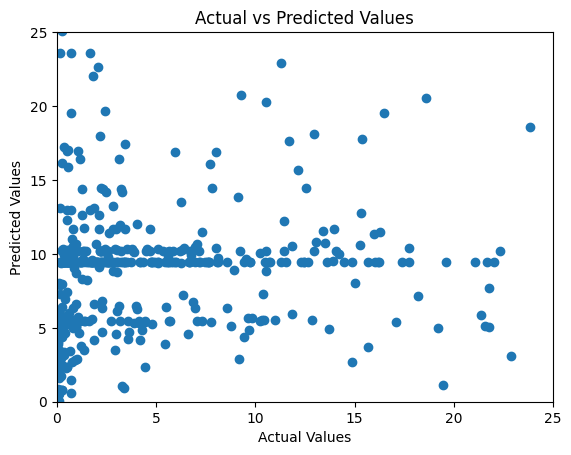

In [117]:
# plot the denormalized values for the actual and predicted values on testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()

